In [1]:
import numpy as np 
import pandas as pd

from scipy.misc import imread
from skimage.filters import sobel_h,sobel_v
from skimage.measure import block_reduce

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf
from multiprocessing import Pool

import time
import skimage
import os

/Users/mohamed/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [3]:
train_path = "/Users/mohamed/Desktop/all/train"

In [4]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels.head()

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

In [5]:
reverse_train_labels = dict((v,k) for k,v in label_names.items())

In [6]:
def get_label(file_ids, train_labels):
    l=train_labels[train_labels.Id.isin(file_ids)]["Target"].values
    l= [[int(i) for i in s.split()] for s in l]
    labels = []
    for i in l:
        L = [0]*28
        for j in i:
            L[j]=1
        labels.append(L)
    return np.array(labels)

In [7]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels.head()

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

In [8]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [9]:
def grad(image):
    grad_x0=sobel_h(image[:,:,0])
    grad_y0=sobel_v(image[:,:,0])
    grad0=np.sqrt(grad_x0*grad_x0+grad_y0*grad_y0).T
    
    grad_x1=sobel_h(image[:,:,1])
    grad_y1=sobel_v(image[:,:,1])
    grad1=np.sqrt(grad_x1*grad_x1+grad_y1*grad_y1).T
    
    grad_x2=sobel_h(image[:,:,2])
    grad_y2=sobel_v(image[:,:,2])
    grad2=np.sqrt(grad_x2*grad_x2+grad_y2*grad_y2).T
    
    grad_x3=sobel_h(image[:,:,3])
    grad_y3=sobel_v(image[:,:,3])
    grad3=np.sqrt(grad_x3*grad_x3+grad_y3*grad_y3).T
    
    return np.array([grad0,grad1,grad2, grad3]).T

def grad_threshold(image, eps):
    
    return (grad(image) > eps)*255

In [10]:
def dirrectional_grad(image,theta):
    
    grad_x0 = np.cos(theta)*sobel_h(image[:,:,0]) + np.sin(theta)*sobel_v(image[:,:,0])
    grad_x1 = np.cos(theta)*sobel_h(image[:,:,1]) + np.sin(theta)*sobel_v(image[:,:,1])
    grad_x2 = np.cos(theta)*sobel_h(image[:,:,2]) + np.sin(theta)*sobel_v(image[:,:,2])
    grad_x3 = np.cos(theta)*sobel_h(image[:,:,3]) + np.sin(theta)*sobel_v(image[:,:,3])
    
    grad0= np.maximum(grad_x0,0).T
    grad1= np.maximum(grad_x1,0).T
    grad2= np.maximum(grad_x2,0).T
    grad3= np.maximum(grad_x3,0).T
    image= np.array([grad0,grad1,grad2, grad3]).T
    return image


# Load data

In [67]:
def load_image(basepath, image_id):

    images = np.zeros(shape=(512,512,4))
    images[:,:,0] = imread(basepath + "/" + image_id + "_green" + ".png")
    images[:,:,1] = imread(basepath + "/" + image_id + "_red" + ".png")
    images[:,:,2] = imread(basepath + "/" + image_id + "_blue" + ".png")
    images[:,:,3] = imread(basepath + "/" + image_id + "_yellow" + ".png")

    return images

def features_aumentation(image):    

    rot=np.arange(0, 360, 45)    
    eps=np.arange(0,128,10)
    
    grad_=True
    dir_grad_=True
    grad_threshold_=True 
    
    a=image
    
    if grad_:
        a=np.append(a,grad(image), axis=2)

    if dir_grad_:
        for i in rot:
            a=np.append(a,dirrectional_grad(image,i), axis=2)
    
    if grad_threshold_:
        for e in eps:      
            a=np.append(a, grad_threshold(image,e), axis=2)
        
    return a
    
def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [68]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):

        self.target_names = '39c89a8e-bbb6-11e8-b2ba-ac1f6b6435d0'
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 512, 512, 4)
        self.basepath = basepath

    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                p = Pool(processes=5)
                images = np.array(p.map(features_aumentation, images))
                p.close()
                yield filenames, get_label(filenames,pd.read_csv("/Users/mohamed/Desktop/train.csv")), images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        
        if idx > 0:
            p = Pool(processes=3)
            images = np.array(p.map(features_aumentation, images))
            p.close()
            yield filenames, get_label(filenames,pd.read_csv("/Users/mohamed/Desktop/train.csv")), images

In [69]:
def return_name(img):
    name=[]
    l=list(label_names.values())
    j=0
    for i in labels[img]:
        if i==1:
            name.append(l[j])
        j+=1
    return name

In [70]:
def make_image_row(image, subax, title, i ):
    subax[0].imshow(image[:,:,4*i], cmap="Greens")
    subax[1].imshow(image[:,:,4*i+1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[:,:,4*i+2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[:,:,4*i+3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

In [71]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 15

In [72]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, labels, images = next(iterator)

# Data shape 

In [73]:
images.shape

(15, 512, 512, 92)

In [74]:
labels.shape

(15, 28)

# Labels with for pool of size 5

In [75]:
for i in range (5):
    print(return_name(i))

['Nucleoplasm', 'Cytokinetic bridge']
['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Golgi apparatus']
['Nuclear bodies']
['Nuclear membrane']
['Microtubule organizing center']


In [76]:
for i in range (5,10,1):
    print(return_name(i))

['Nucleoplasm']
['Nucleoli', 'Cytosol']
['Nucleoplasm']
['Nucleoplasm', 'Nucleoli']
['Golgi apparatus']


In [77]:
for i in range (10,15,1):
    print(return_name(i))

['Mitochondria']
['Plasma membrane']
['Nucleoplasm', 'Aggresome']
['Mitochondria']
['Nucleoli', 'Endoplasmic reticulum']


# Play with filters

### Images not modify

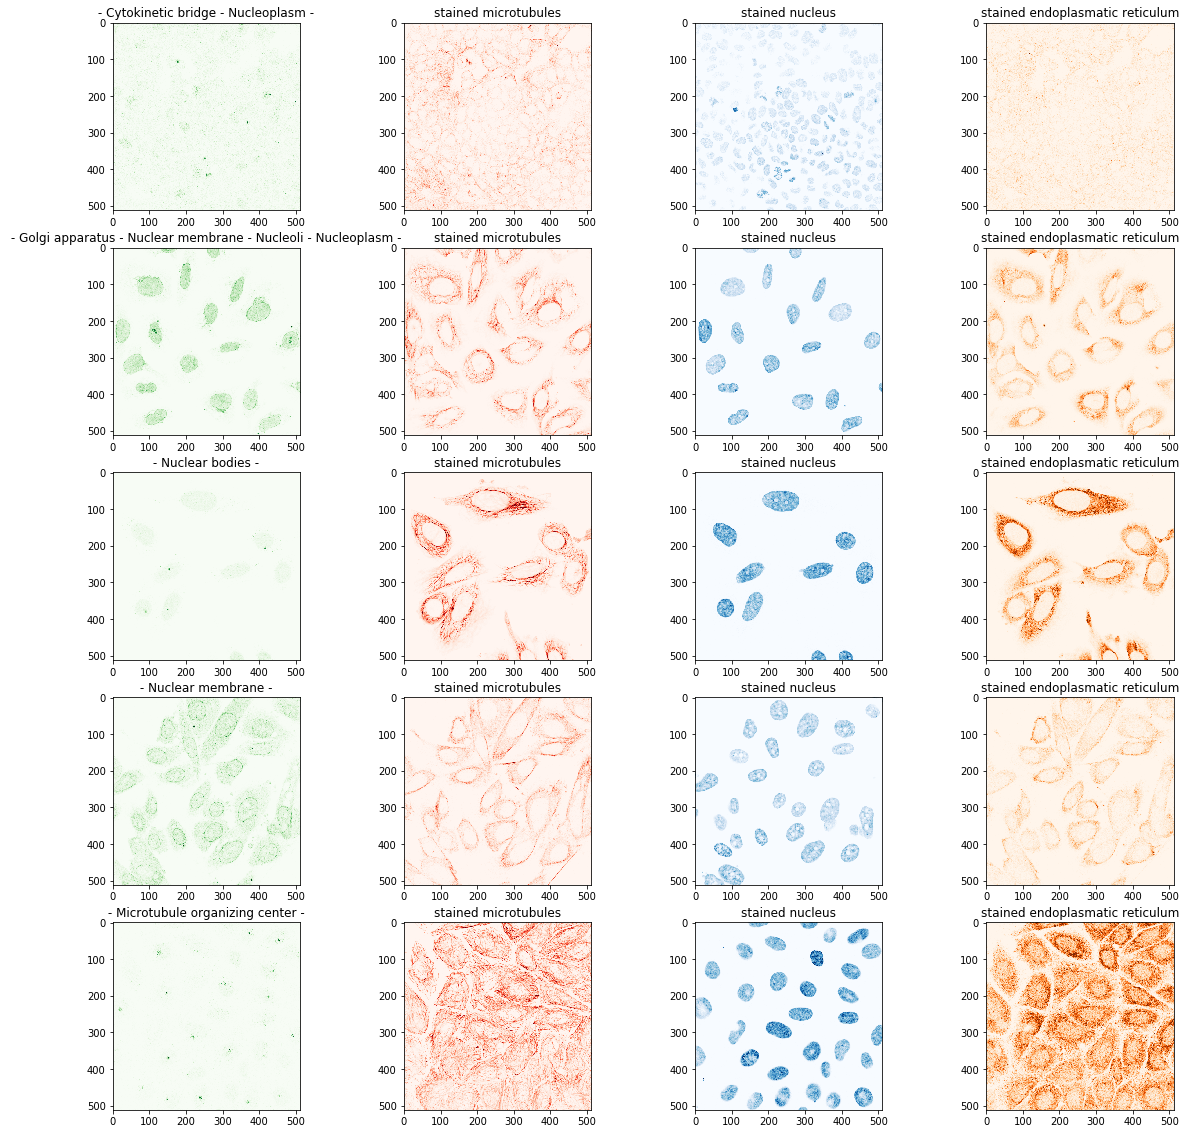

In [78]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=0
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

### Gradient threshold=0

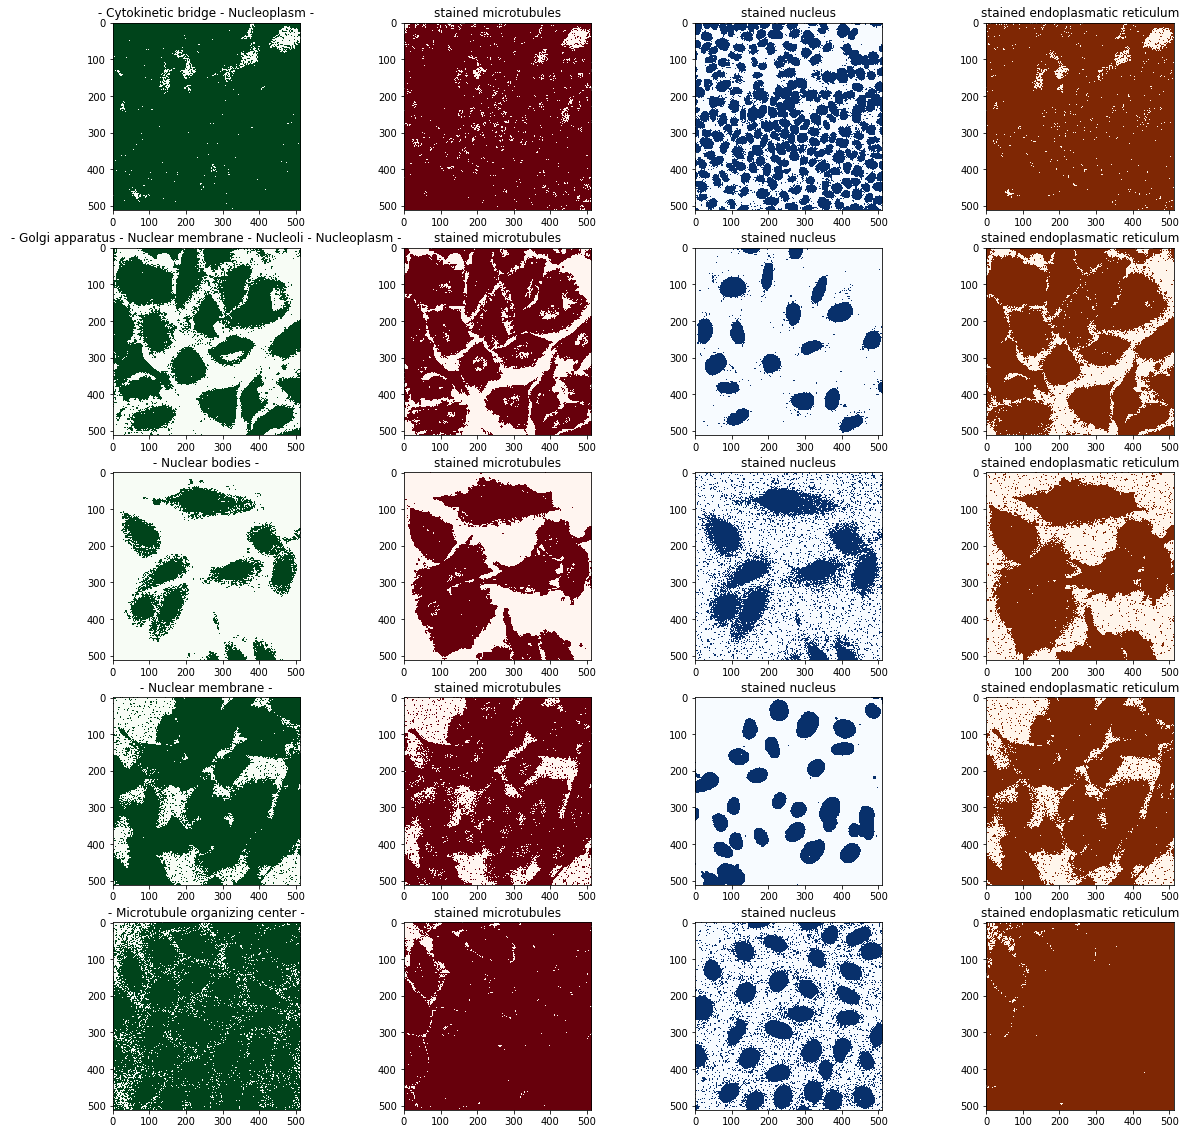

In [83]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=10
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

### Gradient threshold=10

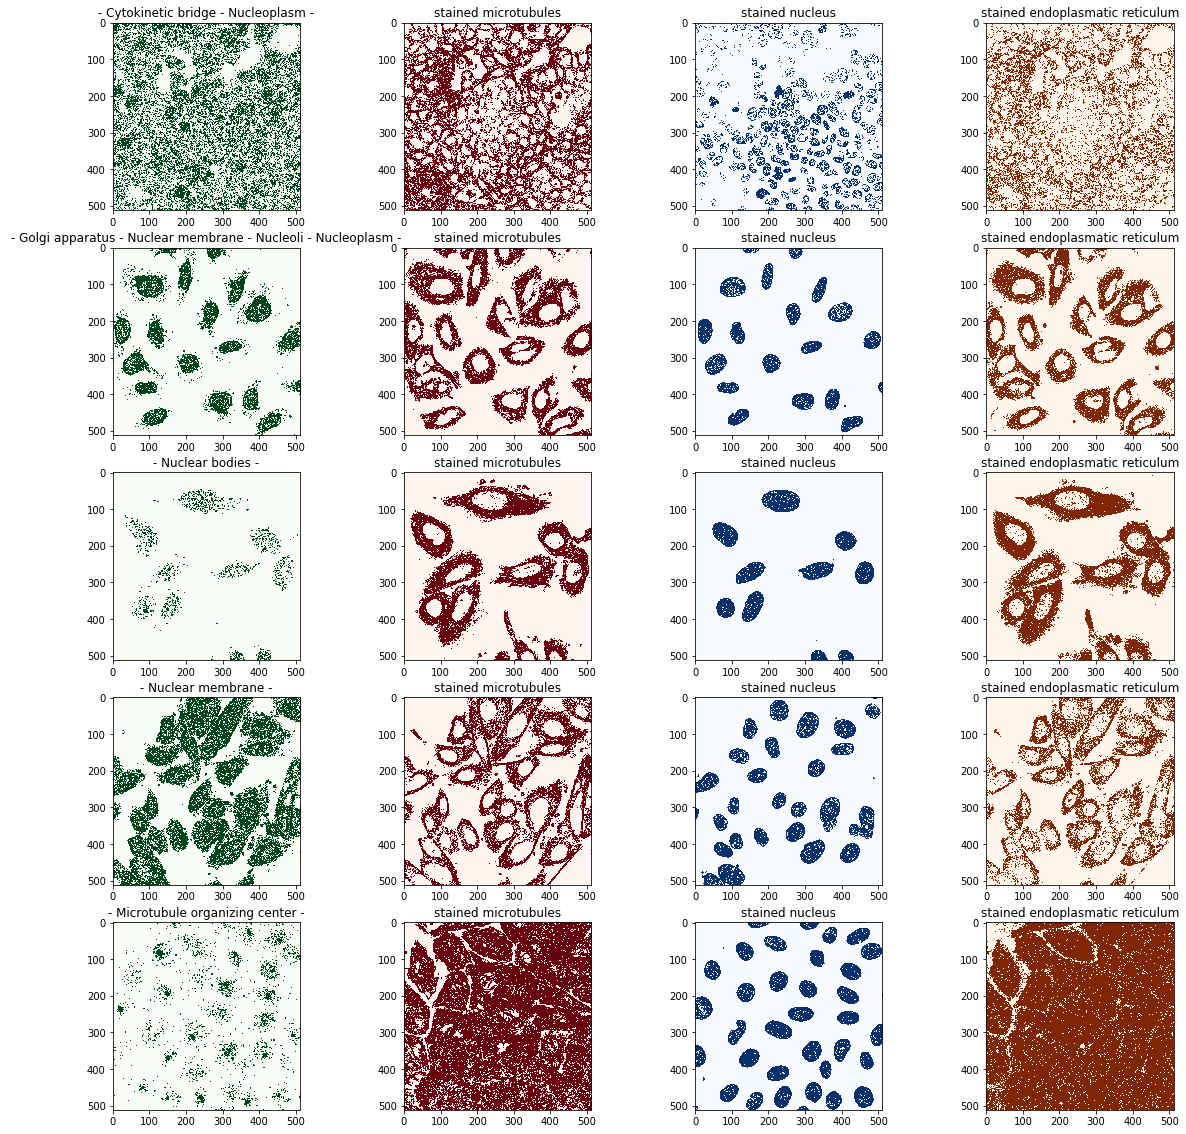

In [80]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=11
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

### Gradient threshold=90

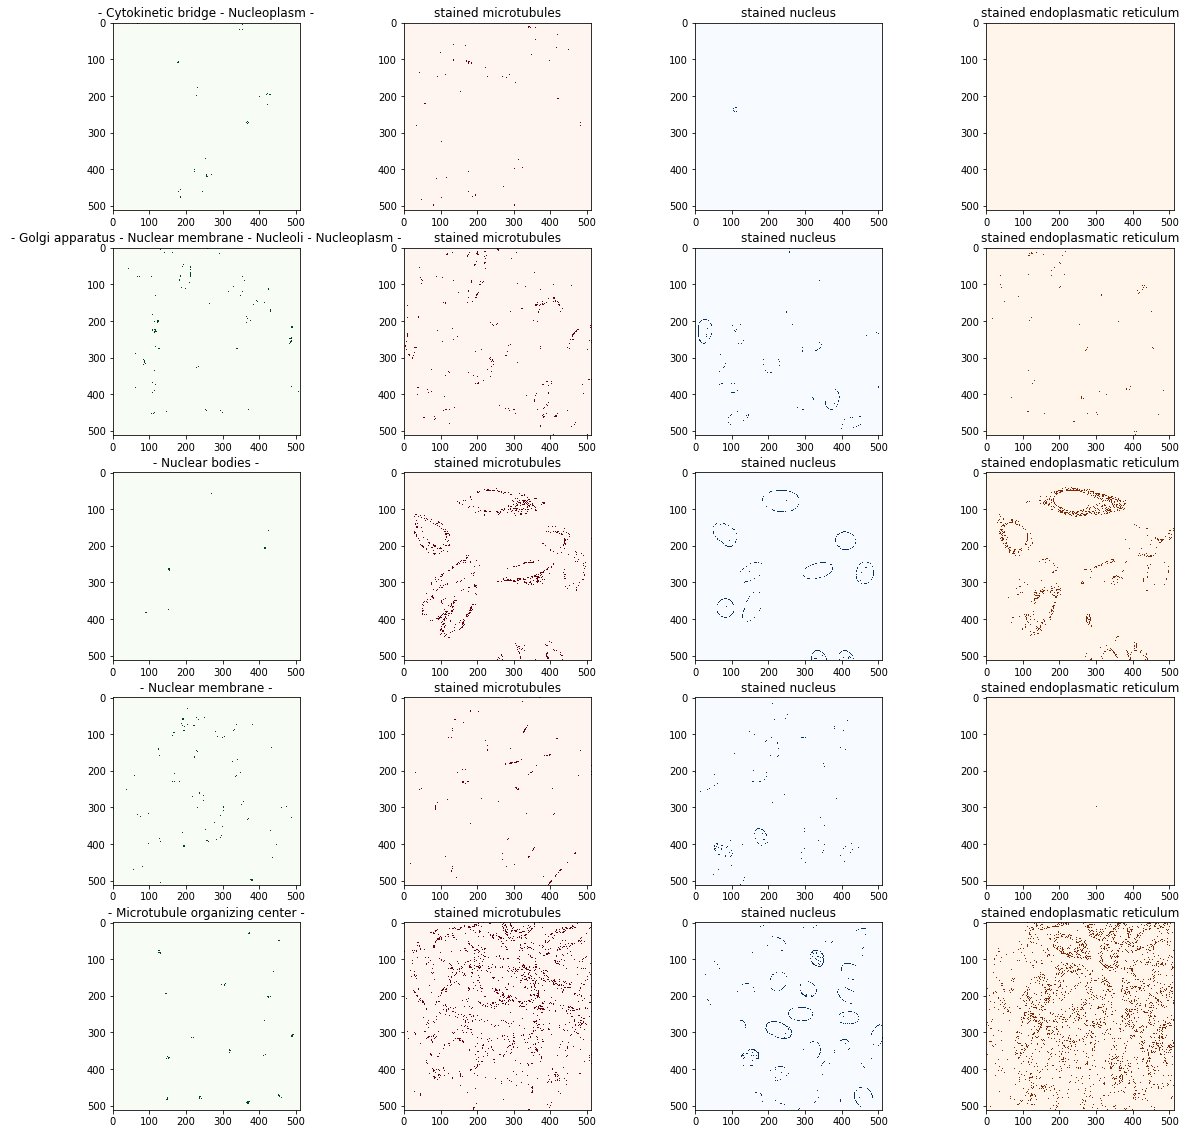

In [84]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=19
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

# Edge detection

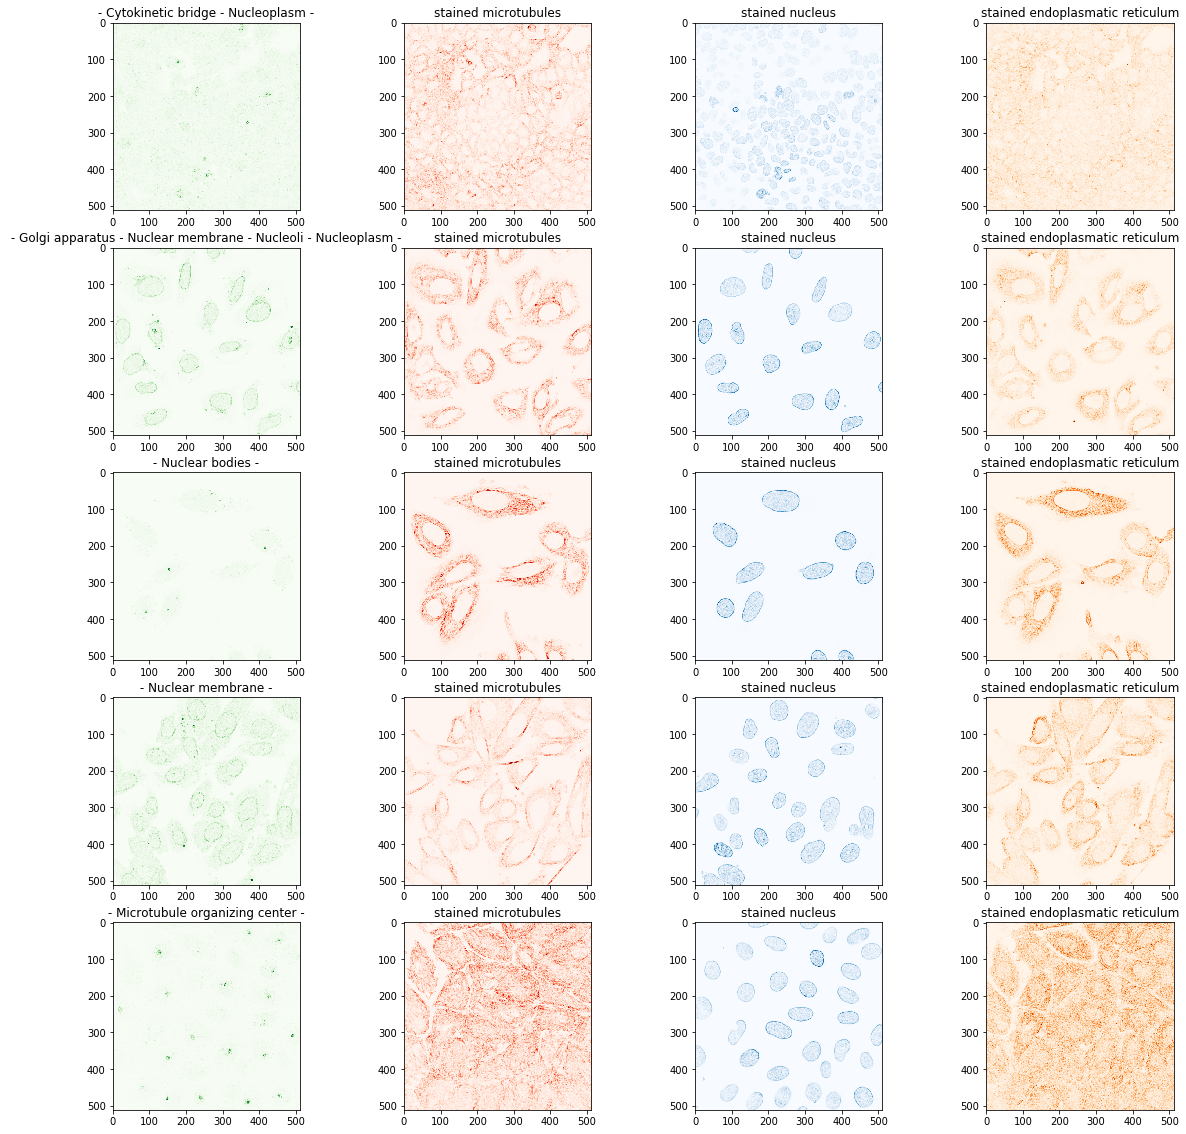

In [85]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=1
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

### Gradient orientations = 0

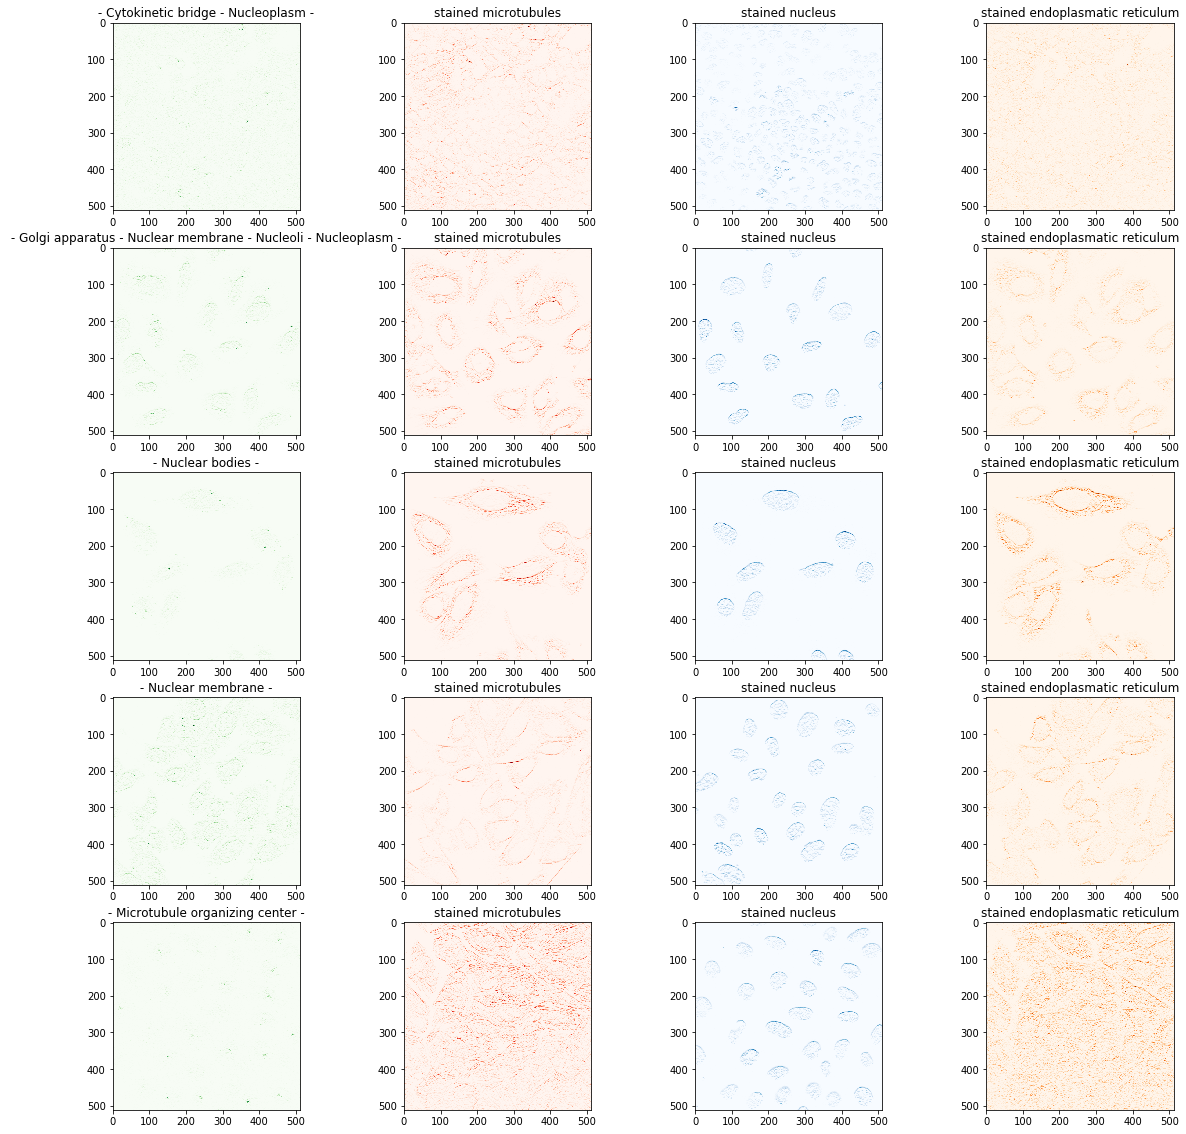

In [86]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=2
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

### Gradient orientations = 45

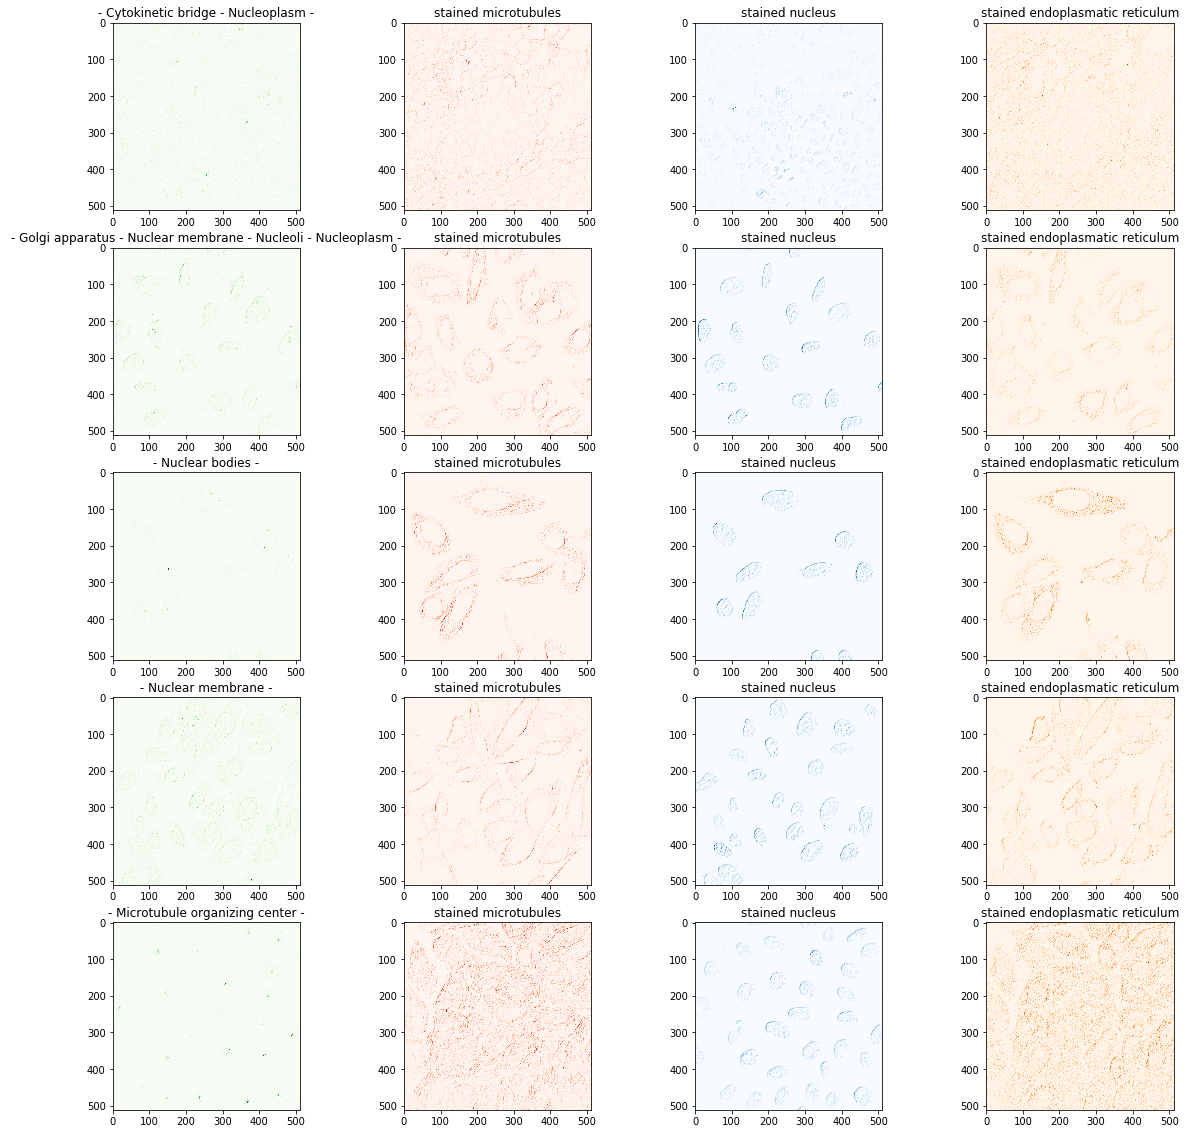

In [87]:
fig, ax = plt.subplots(5,4,figsize=(20,20))
filters=3
for n in range (5):
    make_image_row(images[n], ax[n], make_title(file_ids[n]), filters)

# Plot and save images

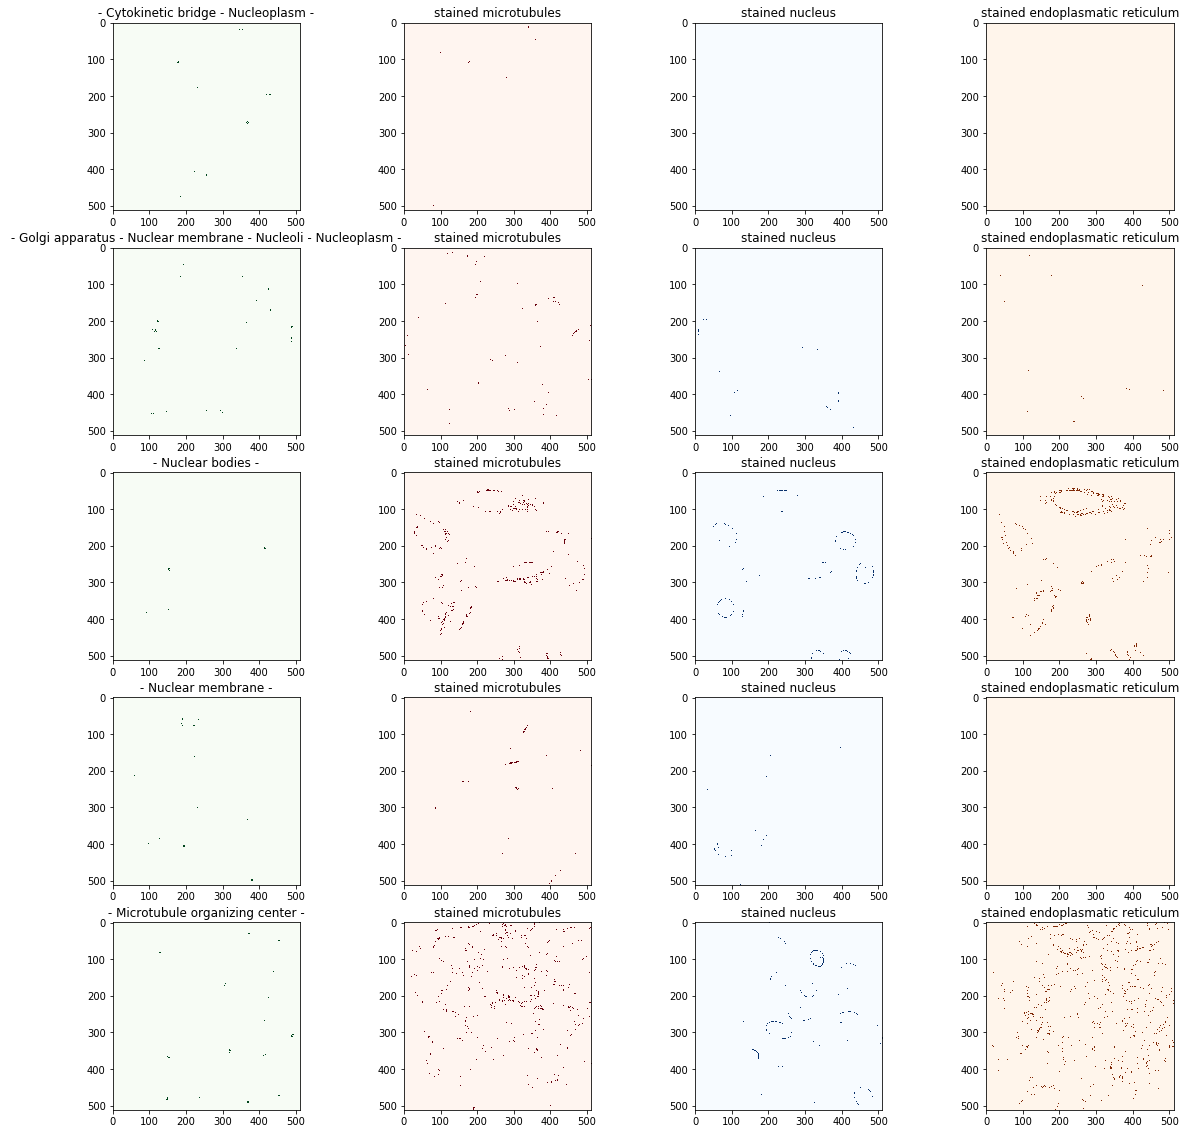

In [88]:
fig, ax = plt.subplots(5,4,figsize=(20,20))

for j in [0,4,9]:
    for i in range(23):
        for n in range (5):
            make_image_row(images[n], ax[n], make_title(file_ids[n]), i)

        #plt.savefig("cells_filter-{}-{}.png".format(i,j))

# Play different combinaison of filters in RBG

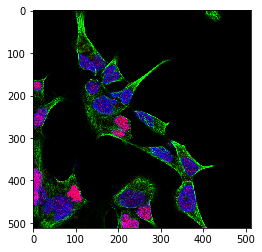

In [89]:
plt.imshow(images[7][:,:,:3].astype(np.uint8))

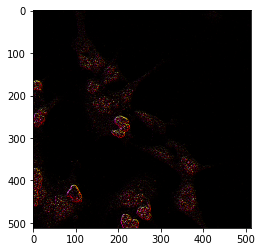

In [90]:
plt.imshow(images[7][:,:,[4,8,12]].astype(np.uint8))

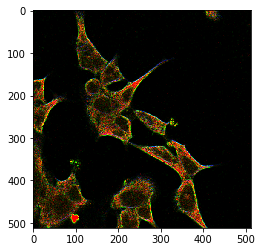

In [91]:
plt.imshow(images[7][:,:,[3,7,9]].astype(np.uint8))

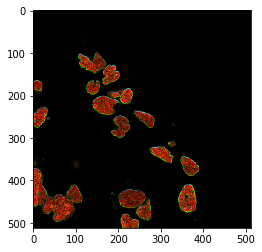

In [92]:
plt.imshow(images[7][:,:,[2,6,10]].astype(np.uint8))

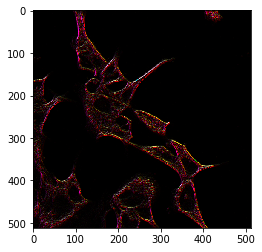

In [93]:
plt.imshow((images[7][:,:,[5,9,13]]).astype(np.uint8))

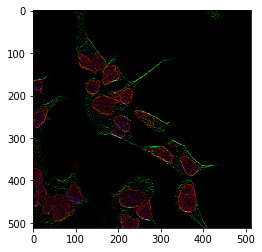

In [94]:
plt.imshow((images[7][:,:,[6,9,20]]).astype(np.uint8))

# Possible futur model

In [95]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import BatchNormalization, add, Dropout, Conv2D, MaxPooling2D,Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l2
import tensorflow as tf

Using TensorFlow backend.


# Model Training

## Model for Grad_threshold

In [99]:
def features_aumentation(image):    

    rot=np.arange(0, 360, 45)    
    eps=np.arange(0,128,20)
    
    grad_=False
    dir_grad_=False
    grad_threshold_=True 
    
    a=image
    
    if grad_:
        a=np.append(a,grad(image), axis=2)

    if dir_grad_:
        for i in rot:
            a=np.append(a,dirrectional_grad(image,i), axis=2)
    
    if grad_threshold_:
        for e in eps:      
            a=np.append(a, grad_threshold(image,e), axis=2)
        
    return a

In [104]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 5

In [105]:
input = Input(shape = images.shape[1:] )

x= input

A = Conv2D(32, kernel_size=10, strides=5, padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
A = MaxPooling2D(pool_size=2, strides=2, padding="valid")(A)
A= BatchNormalization()(A)

B = Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.001))(A)
B = MaxPooling2D(pool_size=2, strides=2, padding="valid")(B)
B= BatchNormalization()(B)

C = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(B)
C = MaxPooling2D(pool_size=2, strides=2, padding="valid")(C)
C= BatchNormalization()(C)

#from the complex model
a = Conv2D(32, kernel_size=10, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
a = MaxPooling2D(pool_size=2, strides=2, padding="valid")(a)
a= BatchNormalization()(a)

b = Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
b = MaxPooling2D(pool_size=2, strides=2, padding="valid")(b)
b= BatchNormalization()(b)

c = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
c = MaxPooling2D(pool_size=2, strides=2, padding="valid")(c)
c= BatchNormalization()(c)

x = add([a,b,c])

#dropout the outpout
C= Flatten()(C)
C=Dropout(0.3)(C)

x= Flatten()(x)
x=Dropout(0.3)(x)

x = Dense((256),activation='relu', kernel_regularizer=l2(0.001))(x)
C = Dense((256),activation='relu', kernel_regularizer=l2(0.001))(C)

x = add([x,C])

x=Dropout (0.3)(x)
x=Dense((512),activation='relu', kernel_regularizer=l2(0.001))(x)

output = Dense(28, activation = "sigmoid")(x)

model_g = Model(inputs=[input], outputs=[output])

model_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 32) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 103, 103, 32) 102432      input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 51, 51, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 51, 51, 32)   128         max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
conv2d_8 (

In [ ]:
model_1 = model_g
model_1.compile(optimizer = "nadam", loss = "binary_crossentropy", metrics=['accuracy'])
nb_epochs = 5

In [ ]:
for e in range (nb_epochs):
    imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
    imageloader.find_matching_data_entries()
    iterator = imageloader.get_loader()
    file_ids, labels, images = next(iterator)
    for i in range (500):
        print("Epoch : {}, Batch : {}".format(e,i))
        file_ids, labels, images = next(iterator)
        model_1.fit(images, labels)

Epoch : 0, Batch : 0
Epoch 1/1


## Model for Grad

In [ ]:
def features_aumentation(image):    

    rot=np.arange(0, 360, 45)    
    eps=np.arange(0,128,20)
    
    grad_=True
    dir_grad_=False
    grad_threshold_=False 
    
    a=image
    
    if grad_:
        a=np.append(a,grad(image), axis=2)

    if dir_grad_:
        for i in rot:
            a=np.append(a,dirrectional_grad(image,i), axis=2)
    
    if grad_threshold_:
        for e in eps:      
            a=np.append(a, grad_threshold(image,e), axis=2)
        
    return a

In [ ]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 50

In [ ]:
model_2 = model_g
model_2.compile(optimizer = "nadam", loss = "binary_crossentropy", , metrics=['accuracy'])
nb_epochs = 5

In [ ]:
for e in range (nb_epochs):
    imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
    imageloader.find_matching_data_entries()
    iterator = imageloader.get_loader()
    file_ids, labels, images = next(iterator)
    for i in range (100):
        file_ids, labels, images = next(iterator)
        model_2.fit(images, labels)

## Model for dir_Grad

In [ ]:
def features_aumentation(image):    

    rot=np.arange(0, 360, 45)    
    eps=np.arange(0,128,20)
    
    grad_=False
    dir_grad_=True
    grad_threshold_=False 
    
    a=image
    
    if grad_:
        a=np.append(a,grad(image), axis=2)

    if dir_grad_:
        for i in rot:
            a=np.append(a,dirrectional_grad(image,i), axis=2)
    
    if grad_threshold_:
        for e in eps:      
            a=np.append(a, grad_threshold(image,e), axis=2)
        
    return a

In [ ]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 50

In [ ]:
model_3 = model_g
model_3.compile(optimizer = "nadam", loss = "binary_crossentropy", , metrics=['accuracy'])
nb_epochs = 5

In [ ]:
for e in range (nb_epochs):
    imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
    imageloader.find_matching_data_entries()
    iterator = imageloader.get_loader()
    file_ids, labels, images = next(iterator)

    for i in range (100):
        file_ids, labels, images = next(iterator)
        model_3.fit(images, labels)

# Evaluation 

In [ ]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 5000

In [ ]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, labels, images = next(iterator)

In [ ]:
model_1.evaluate(train_input_data, train_target_data, batch_size=250)

In [ ]:
model_2.evaluate(train_input_data, train_target_data, batch_size=250)

In [ ]:
model_3.evaluate(train_input_data, train_target_data, batch_size=250)

# Data augmentation: not finish

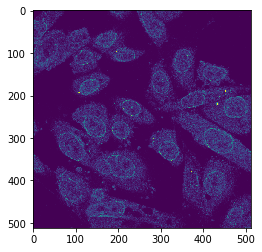

In [94]:
def data_aug(image, angle, zoom):
    (h, w) = (512,512)
    center = (h//2, w//2)
    M = cv2.getRotationMatrix2D(center, angle, zoom)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

plt.imshow(data_aug(images[3], 270, 1).astype(np.uint8)[:,:,0])

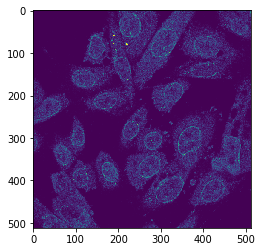

In [92]:
plt.imshow(images[3].astype(np.uint8)[:,:,0])

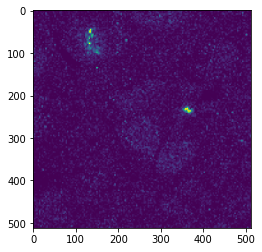

In [95]:
def data_aug_rand(image, angle, zoom):
    (h, w) = (512,512)
    center = (np.random.randint(512), np.random.randint(512))
    M = cv2.getRotationMatrix2D(center, angle, zoom)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

plt.imshow(data_aug_rand(images[0], 90, 3).astype(np.uint8)[:,:,0])

In [96]:
def data_aug(image):
    #!!!!!!!!!!!!!!!!!!!! next time use symmetry !!!!!!!!!!!!!!!!!!
    
    angle = [ 90, 180, 270 ] 
    zoom = 1
    (h, w) = image.shape[1:3]
    center = (w // 2, h // 2)
    image_bis = image[0]
    image_f = image
    for a in angle:
        M = cv2.getRotationMatrix2D(center, a, zoom)
        rotated0 = cv2.warpAffine(image_bis[:,:,0], M, (w, h))
        rotated1 = cv2.warpAffine(image_bis[:,:,1], M, (w, h))
        rotated2 = cv2.warpAffine(image_bis[:,:,2], M, (w, h))
        rotated3 = cv2.warpAffine(image_bis[:,:,3], M, (w, h))
        rotated = np.array([np.array([rotated0.T, rotated1.T, rotated2.T, rotated3.T]).T])
        image_f = np.append(image_f, rotated, axis=0) 
    
    return image_f

#plt.imshow(data_aug(images[0], 90, 1).astype(np.uint8)[:,:,0])

In [97]:
def image_block(images,block_size,orientations):
    theta=np.linspace(0,np.pi,orientations,endpoint=False)
    v_x=np.cos(theta)
    v_y=np.sin(theta)
    edge_x=np.empty_like(images)
    edge_y=np.empty_like(images)
    for idx,image in enumerate(images):
        edge_x[idx]=sobel_h(image)
        edge_y[idx]=sobel_v(image)

    #print("edge_x",edge_x.shape,"edge_y",edge_y.shape)
    edges= edge_x[:,:,:,np.newaxis]*v_x+edge_y[:,:,:,np.newaxis]*v_y
    #print("edges",edges.shape)
    features=np.maximum(edges,0)
    block=(1,block_size,block_size,1)
    block_features=block_reduce(features,block,np.mean)
    #print("block_features",block_features.shape)
    return np.array(block_features)

In [98]:
def make_image_row_block(image, subax, title, block_size, orientations,r):
    subax[0].imshow(image_block(image,block_size,orientations)[:,:,:,r][0], cmap="Greens")
    subax[1].imshow(image_block(image,block_size,orientations)[:,:,:,r][1], cmap="Reds")
    subax[1].set_title("stained microtubules block_size={}, r={}".format(block_size,r))
    subax[2].imshow(image_block(image,block_size,orientations)[:,:,:,r][2], cmap="Blues")
    subax[2].set_title("stained nucleus block_size={}, r={}".format(block_size,r))
    subax[3].imshow(image_block(image,block_size,orientations)[:,:,:,r][3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic block_size={}, r={}".format(block_size,r))
    subax[0].set_title(title)
    return subax

In [99]:
block=np.arange(1,11,1)
block=[5,10,15,30,50]
rotations=4

In [106]:
train_labels = pd.read_csv("/Users/mohamed/Desktop/train.csv")
train_labels = train_labels.apply(fill_targets, axis=1)
your_choice = list(label_names.values())
your_batch_size = 15

In [107]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, labels, images = next(iterator)

In [108]:
imag = images[:,:,:,:4]
img=imag[3].T
images2 = np.array([img])

In [109]:
images2.shape

(1, 4, 512, 512)

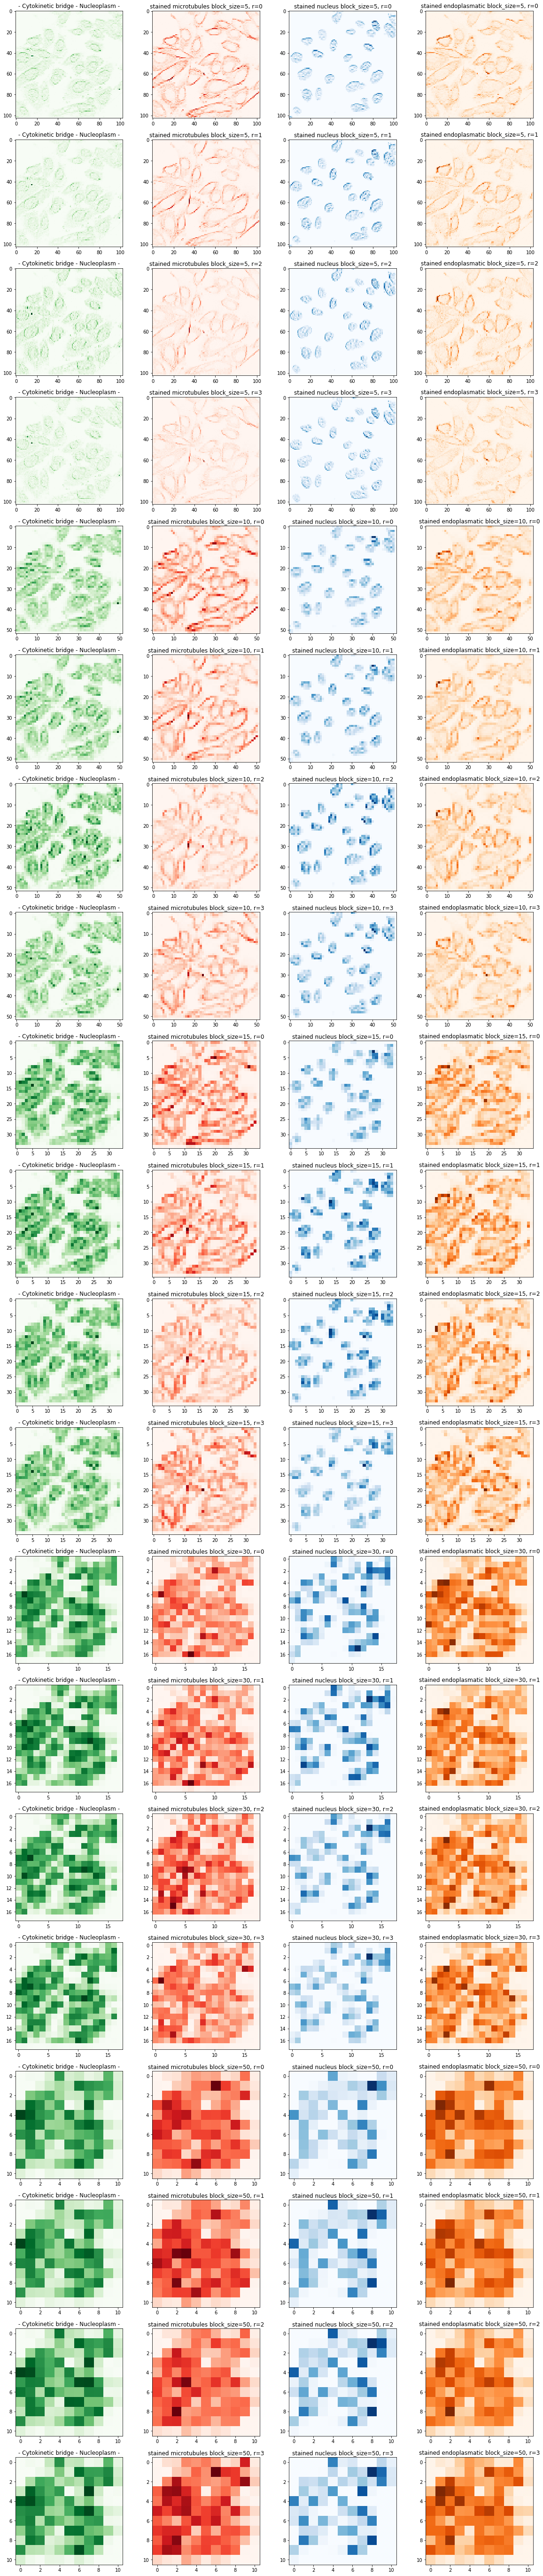

In [113]:
fig, ax = plt.subplots(len(block)*rotations,4,figsize=(20,5*len(block)*rotations))
Idx=0
for n in range(1):
    for b in block:
        for r in range (rotations):
            make_image_row_block(images2[n], ax[n+Idx], make_title(file_ids[n]), b, rotations, r)
            Idx+=1
#plt.savefig("blocks.png")

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html